Ce notebook va servir à la création de notre vecteur Y et notre tableau X de 2006 à 2022 sur la saison estivale afin d'appliquer ensuite nos modèles de prédiction.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, LineString, Polygon

In [2]:
!pip install requests py7zr geopandas openpyxl tqdm s3fs PyYAML xlrd
!pip install git+https://github.com/inseefrlab/cartiflette@80b8a5a28371feb6df31d55bcc2617948a5f9b1a

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.2/141.2 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.3/411.3 kB 43.1 MB/s eta 0:00:00
  Cloning https://github.com/inseefrlab/cartiflette (to revision 80b8a5a28371feb6df31d55bcc2617948a5f9b1a) to /tmp/pip-req-build-3x1rubhe
  Running command git clone --filter=blob:none --quiet https://github.com/inseefrlab/cartiflette /tmp/pip-req-build-3x1rubhe
  Running command git rev-parse -q --verify 'sha^80b8a5a28371feb6df31d55bcc2617948a5f9b1a'
  Running 

In [3]:
import cartiflette.s3 as s3

## Base de données des communes des Landes ##

Pour avoir toutes les communes des Landes et pas uniquement celles présente dans BDIFF, on importe la base suivante

In [4]:
data_communes = 'Codes-INSEE-communes-geolocalisees.csv'

df_communes = pd.read_csv('Codes-INSEE-communes-geolocalisees.csv', encoding='ISO-8859-1')
#print(df_communes.head())

# Filtrer pour garder uniquement les communes des Landes (codes INSEE commençant par '40')
data_landes = df_communes[df_communes['Insee'].str.startswith('40')]
print(data_landes.head())

     Insee                    Nom  Altitude  code_postal  longitude_radian  \
1555  4001                 Aiglun     780.0         4510          0.106989   
1556  4004  Allemagne-en-Provence     420.0  04550|04500          0.104851   
1557  4005                 Allons    1073.0         4170          0.115095   
1558  4006                  Allos    1414.0         4260          0.115652   
1559  4007                 Angles     961.0         4170          0.114445   

      latitude_radian  pop99  surface  
1555         0.769070   1038    14.58  
1556         0.764158    379    33.18  
1557         0.767567     81    41.96  
1558         0.772177    637   117.31  
1559         0.766970     67    10.02  


## Création du vecteur Y ##

Y est un vecteur de 0 et de 1. Chaque ligne correspond à une commune, qui vont être répétées de 2006 à 2022 :
- $Y_1$ = 1 si il y a eu au moins un feu dans la commune 1 sur la période estivale en 2006, 0 sinon
- $Y_2$ = 1 si il y a eu au moins un feu dans la commune 2 sur la période estivale en 2006, 0 sinon
  ...

In [5]:
data = 'combine.csv'

df = pd.read_csv('combine.csv', sep=';')
#print(df.head())

# Pour les Landes
bdiff_landes = df[df['Département'] == '40']
print(bdiff_landes.head())

     Année  Numéro Département Code INSEE  Nom de la commune  \
652   2006    1876          40      40006          Arengosse   
653   2006    1877          40      40151             Lesgor   
654   2006    1878          40      40108             Gastes   
655   2006    1879          40      40210  Onesse-et-Laharie   
656   2006    1881          40      40167              Luxey   

    Date de première alerte Origine de l'alerte  \
652        26/07/2006 19:40         Indéterminé   
653        17/07/2006 15:29         Indéterminé   
654        25/04/2006 18:40         Indéterminé   
655        17/07/2006 18:20         Indéterminé   
656        27/07/2006 10:49         Indéterminé   

     Moyens de première intervention  Surface parcourue (m2)  \
652                              NaN                    5000   
653                              NaN                   66000   
654                              NaN                     400   
655                              NaN                

*Test uniquement pour l'année 2006*

In [6]:
# Conversion du format de la date
bdiff_landes.loc[:, 'Date de première alerte'] = pd.to_datetime(bdiff_landes['Date de première alerte'], format='%d/%m/%Y %H:%M')

# Filtrer pour l'été 2006
bdiff_landes_2006 = bdiff_landes[bdiff_landes['Année'] == 2006]
df_summer = bdiff_landes_2006[bdiff_landes_2006['Date de première alerte'].dt.month.isin([6, 7, 8])]

# Aggrégation par commune avec vérification des incendies
feu_par_commune = df_summer.groupby('Code INSEE').size().gt(0).reset_index(name='Feu en été')

# Convertir les valeurs en 1 et 0
feu_par_commune['Feu en été'] = feu_par_commune['Feu en été'].astype(int)

# Liste complète des communes des Landes
communes_landes = data_landes[['Insee']].rename(columns={'Insee': 'Code INSEE'})

# Jointure avec la liste des communes des Landes pour inclure toutes les communes
Y = communes_landes.merge(feu_par_commune, on='Code INSEE', how='left')
Y['Feu en été'] = Y['Feu en été'].fillna(0).astype(int)

print(Y)

AttributeError: Can only use .dt accessor with datetimelike values

*De 2006 à 2022, avec toutes les communes*

In [7]:
data_communes = 'Codes-INSEE-communes-geolocalisees.csv'
df_communes = pd.read_csv('Codes-INSEE-communes-geolocalisees.csv', encoding='ISO-8859-1')
data_landes = df_communes[df_communes['Insee'].str.startswith('40')]
data = 'combine.csv'
df = pd.read_csv('combine.csv', sep=';')
bdiff_landes = df[df['Département'] == '40']
bdiff_landes['Date de première alerte'] = pd.to_datetime(bdiff_landes['Date de première alerte'], format='%d/%m/%Y %H:%M')
communes_landes = data_landes[['Insee']].rename(columns={'Insee': 'Code INSEE'})

# Initialisation du DataFrame final
Y = pd.DataFrame()

annees = [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2022]

for annee in annees:
    df_annee = bdiff_landes[bdiff_landes['Année'] == annee]
    df_summer = df_annee[df_annee['Date de première alerte'].dt.month.isin([6, 7, 8])]
    feu_par_commune = df_summer.groupby('Code INSEE').size().gt(0).reset_index(name='Feu en été')
    feu_par_commune['Feu en été'] = feu_par_commune['Feu en été'].astype(int)
    resultat_annuel = communes_landes.merge(feu_par_commune, on='Code INSEE', how='left')
    resultat_annuel['Feu en été'] = resultat_annuel['Feu en été'].fillna(0).astype(int)
    resultat_annuel['Année'] = annee  # Ajout de la colonne Année
    Y = pd.concat([Y, resultat_annuel], ignore_index=True)

print(Y)

     Code INSEE  Feu en été  Année
0          4001           0   2006
1          4004           0   2006
2          4005           0   2006
3          4006           0   2006
4          4007           0   2006
...         ...         ...    ...
6539      40330           0   2022
6540      40331           1   2022
6541      40332           1   2022
6542      40333           0   2022
6543      40334           0   2022

[6544 rows x 3 columns]


/tmp/ipykernel_249/1352777133.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdiff_landes['Date de première alerte'] = pd.to_datetime(bdiff_landes['Date de première alerte'], format='%d/%m/%Y %H:%M')


In [8]:
Y.to_csv('feux_par_communes.csv', index=False)

## Correspondance commune / maille ##

Afin de pouvoir manipuler les IFM (calculés au coin de chaque maille), et le nombre de feu (connu par commune), et pouvoir ensuite faire nos régressions par maille, il faut arriver à trouver le lien entre les communes et les mailles.

Pour ça, nous avons à notre disposition la base maille_landes, correspondant aux mailles SAFRAN utilisés par le DRIAS pour calculer les IFM, et la base Codes-INSEE_communes, avec toutes les communes des Landes.

*Pour rappel, la base Codes-INSEE*

In [9]:
data_communes = 'Codes-INSEE-communes-geolocalisees.csv'

df_communes = pd.read_csv('Codes-INSEE-communes-geolocalisees.csv', encoding='ISO-8859-1')
#print(df_communes.head())

# Filtrer pour garder uniquement les communes des Landes (codes INSEE commençant par '40')
data_landes = df_communes[df_communes['Insee'].str.startswith('40')]
print(data_landes.head())

     Insee                    Nom  Altitude  code_postal  longitude_radian  \
1555  4001                 Aiglun     780.0         4510          0.106989   
1556  4004  Allemagne-en-Provence     420.0  04550|04500          0.104851   
1557  4005                 Allons    1073.0         4170          0.115095   
1558  4006                  Allos    1414.0         4260          0.115652   
1559  4007                 Angles     961.0         4170          0.114445   

      latitude_radian  pop99  surface  
1555         0.769070   1038    14.58  
1556         0.764158    379    33.18  
1557         0.767567     81    41.96  
1558         0.772177    637   117.31  
1559         0.766970     67    10.02  


*Et la base mailles_landes*

In [10]:
data_safran = 'mailles_landes_etendues.csv'

df_safran = pd.read_csv(data_safran)
print(df_safran.head())

   Unnamed: 0  maille_safran  maille_drias   latitude  longitude  altitude  \
0        6423           7577          6181  44.591720  -1.239108        28   
1        6424           7578          6182  44.594946  -1.138519        18   
2        6425           7579          6183  44.598081  -1.037918        12   
3        6504           7659          6038  44.519847  -1.234534        32   
4        6505           7660          6039  44.523069  -1.134073        24   

    departement region_avant_2016          region2016          nature  ...  \
0  33 - Gironde         Aquitaine  Nouvelle-Aquitaine  Limite côtière  ...   
1  33 - Gironde         Aquitaine  Nouvelle-Aquitaine      Territoire  ...   
2  33 - Gironde         Aquitaine  Nouvelle-Aquitaine      Territoire  ...   
3  33 - Gironde         Aquitaine  Nouvelle-Aquitaine  Limite côtière  ...   
4  33 - Gironde         Aquitaine  Nouvelle-Aquitaine      Territoire  ...   

   clc_311  clc_312  clc_313   rupro  rupromin  rupromax   pro

# 1- Correspondance avec la base INSEE ?
Dessiner la carte des communes des Landes en plaçant des points aux coordonnées latitude/longitude des deux bases afin de voir si ils coincident

In [11]:
## 1- télécharger la carte des communes

communes_landes = s3.download_vectorfile_url_all(
    values="40",  # Code département des Landes
    crs=4326,  
    borders="COMMUNE",  
    vectorfile_format="topojson",
    filter_by="DEPARTEMENT",  
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022
)

# Calcul de l'aire des communes en mètre carré (projection en Lambert-93)
communes_landes["area"] = communes_landes.to_crs(2154).area

https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE/crs=4326/DEPARTEMENT=40/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 1.12MiB [00:00, 51.6MiB/s]
ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


In [12]:
## 2- convertir les coordonnées de la base insee en degré et non pas en radians

data_landes.loc[:, 'longitude_degrees'] = np.degrees(data_landes.loc[:, 'longitude_radian'])
data_landes.loc[:, 'latitude_degrees'] = np.degrees(data_landes.loc[:, 'latitude_radian'])

print(data_landes.head())

     Insee                    Nom  Altitude  code_postal  longitude_radian  \
1555  4001                 Aiglun     780.0         4510          0.106989   
1556  4004  Allemagne-en-Provence     420.0  04550|04500          0.104851   
1557  4005                 Allons    1073.0         4170          0.115095   
1558  4006                  Allos    1414.0         4260          0.115652   
1559  4007                 Angles     961.0         4170          0.114445   

      latitude_radian  pop99  surface  longitude_degrees  latitude_degrees  
1555         0.769070   1038    14.58           6.130000         44.064445  
1556         0.764158    379    33.18           6.007500         43.783054  
1557         0.767567     81    41.96           6.594444         43.978333  
1558         0.772177    637   117.31           6.626389         44.242500  
1559         0.766970     67    10.02           6.557222         43.944168  


/tmp/ipykernel_249/4083701067.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_landes.loc[:, 'longitude_degrees'] = np.degrees(data_landes.loc[:, 'longitude_radian'])
/tmp/ipykernel_249/4083701067.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_landes.loc[:, 'latitude_degrees'] = np.degrees(data_landes.loc[:, 'latitude_radian'])


In [13]:
## 3- conversion des GeoDataFrame

geometry_landes = [Point(xy) for xy in zip(data_landes['longitude_degrees'], data_landes['latitude_degrees'])]
geo_data_landes = gpd.GeoDataFrame(data_landes, geometry=geometry_landes)

geometry_safran = [Point(xy) for xy in zip(df_safran['longitude'], df_safran['latitude'])]
geo_df_safran = gpd.GeoDataFrame(df_safran, geometry=geometry_safran)

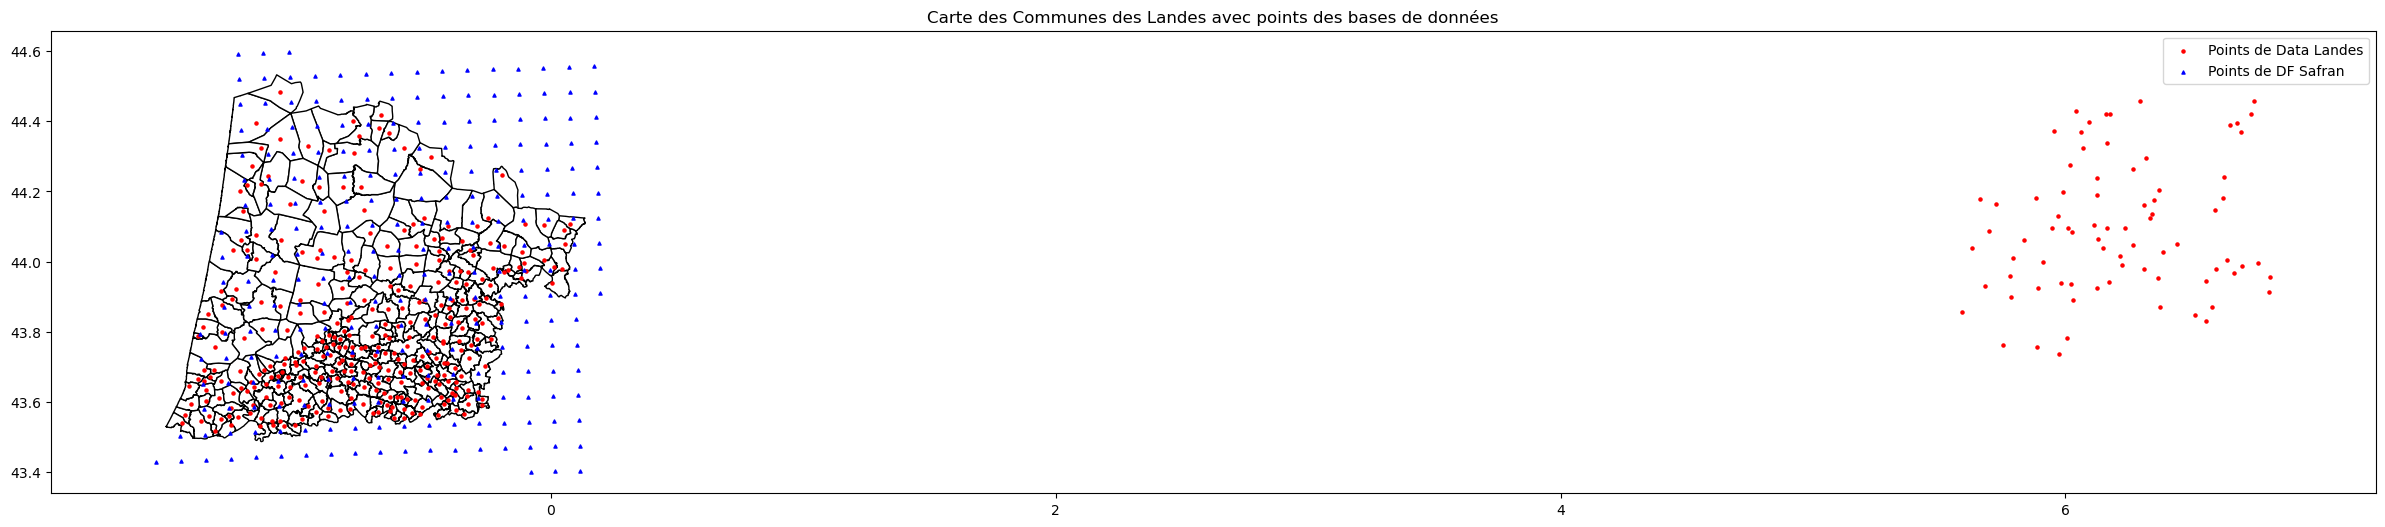

In [14]:
## 4- visualisation avec la shapeline des communes 

# Assurer que toutes les données sont dans le même système de coordonnées
geo_data_landes = geo_data_landes.set_crs(epsg=4326)  # WGS 84
geo_df_safran = geo_df_safran.set_crs(epsg=4326)  # WGS 84
communes_landes = communes_landes.to_crs(epsg=4326)  # Convertir si différent

fig, ax = plt.subplots(figsize=(30, 30))
communes_landes.plot(ax=ax, color='white', edgecolor='black')

# Ajouter les points de geo_data_landes et geo_df_safran à la carte
geo_data_landes.plot(ax=ax, marker='o', color='red', markersize=5, label='Points de Data Landes')
geo_df_safran.plot(ax=ax, marker='^', color='blue', markersize=5, label='Points de DF Safran')

plt.title('Carte des Communes des Landes avec points des bases de données')
plt.legend()

plt.show()


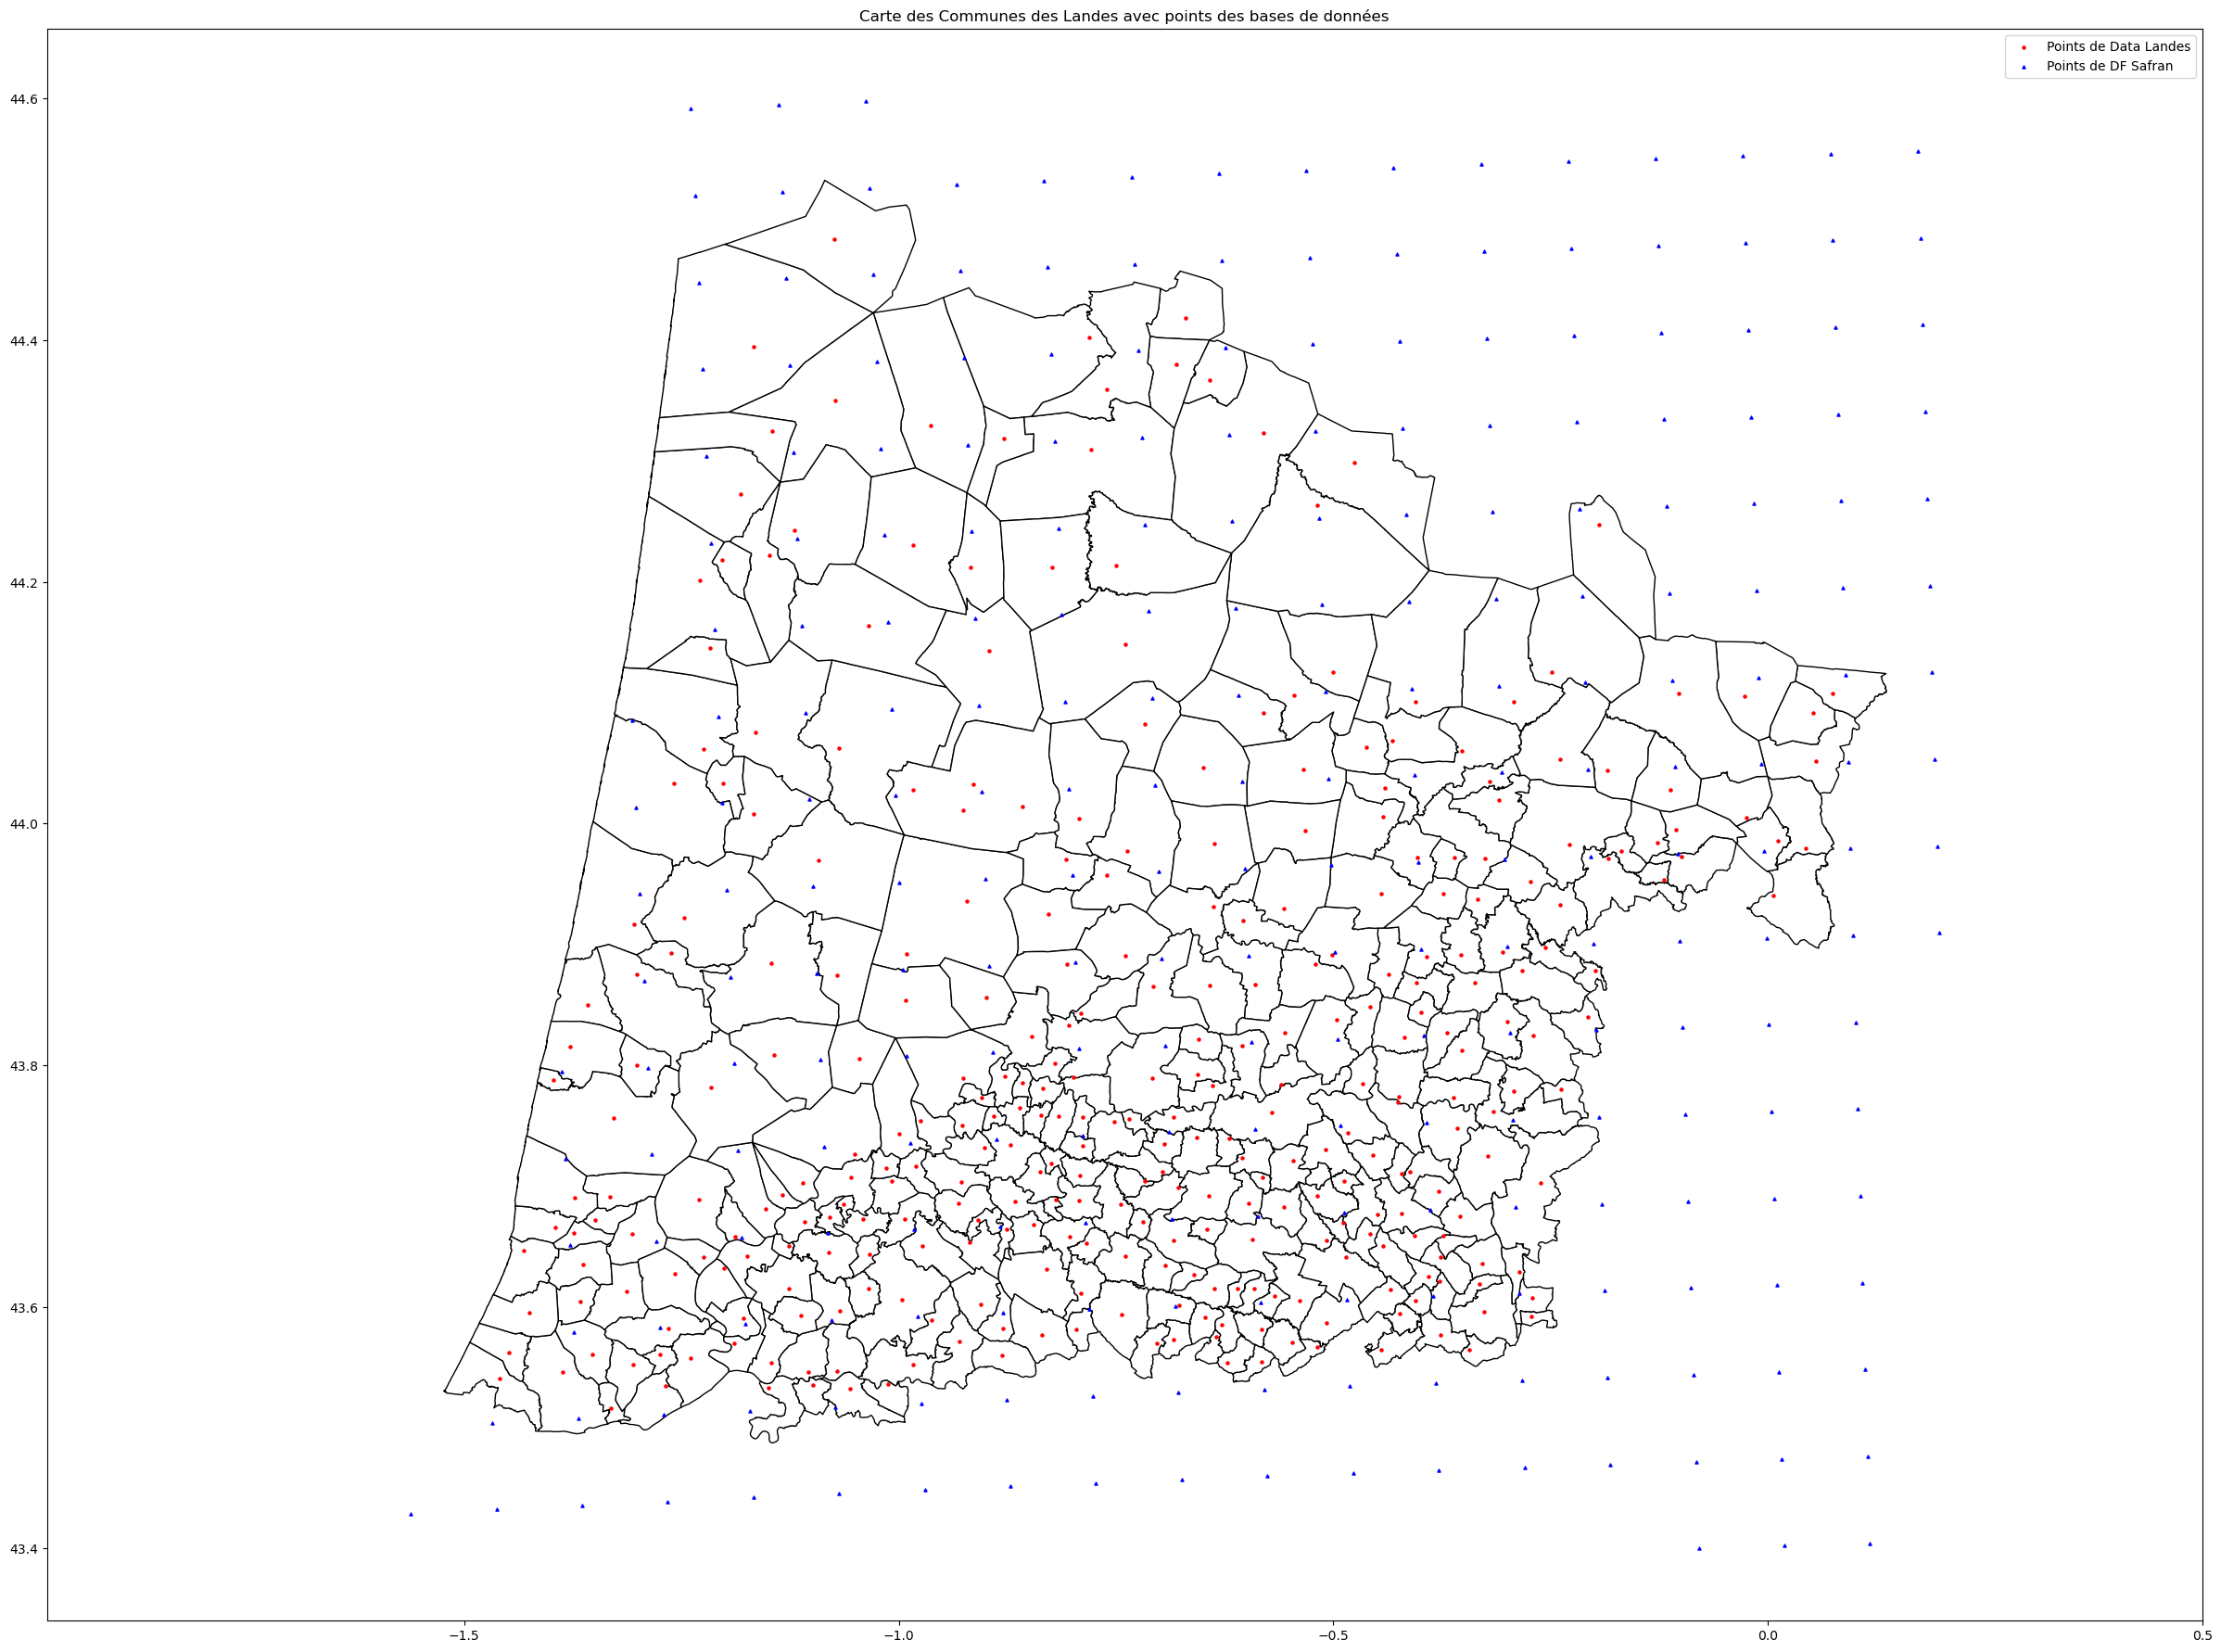

In [15]:
## 5- zoom sur la partie gauche

# Assurer que toutes les données sont dans le même système de coordonnées
geo_data_landes = geo_data_landes.set_crs(epsg=4326)  # WGS 84
geo_df_safran = geo_df_safran.set_crs(epsg=4326)  # WGS 84
communes_landes = communes_landes.to_crs(epsg=4326)  # Convertir si différent

fig, ax = plt.subplots(figsize=(30, 30))
communes_landes.plot(ax=ax, color='white', edgecolor='black')

# Ajouter les points de geo_data_landes et geo_df_safran à la carte
geo_data_landes.plot(ax=ax, marker='o', color='red', markersize=5, label='Points de Data Landes')
geo_df_safran.plot(ax=ax, marker='^', color='blue', markersize=5, label='Points de DF Safran')

ax.set_xlim(left=None, right=0.5)  

plt.title('Carte des Communes des Landes avec points des bases de données')
plt.legend()

plt.show()


On remarque que ça ne correspond pas bien.

# 2- Quadrillage des mailles SAFRAN

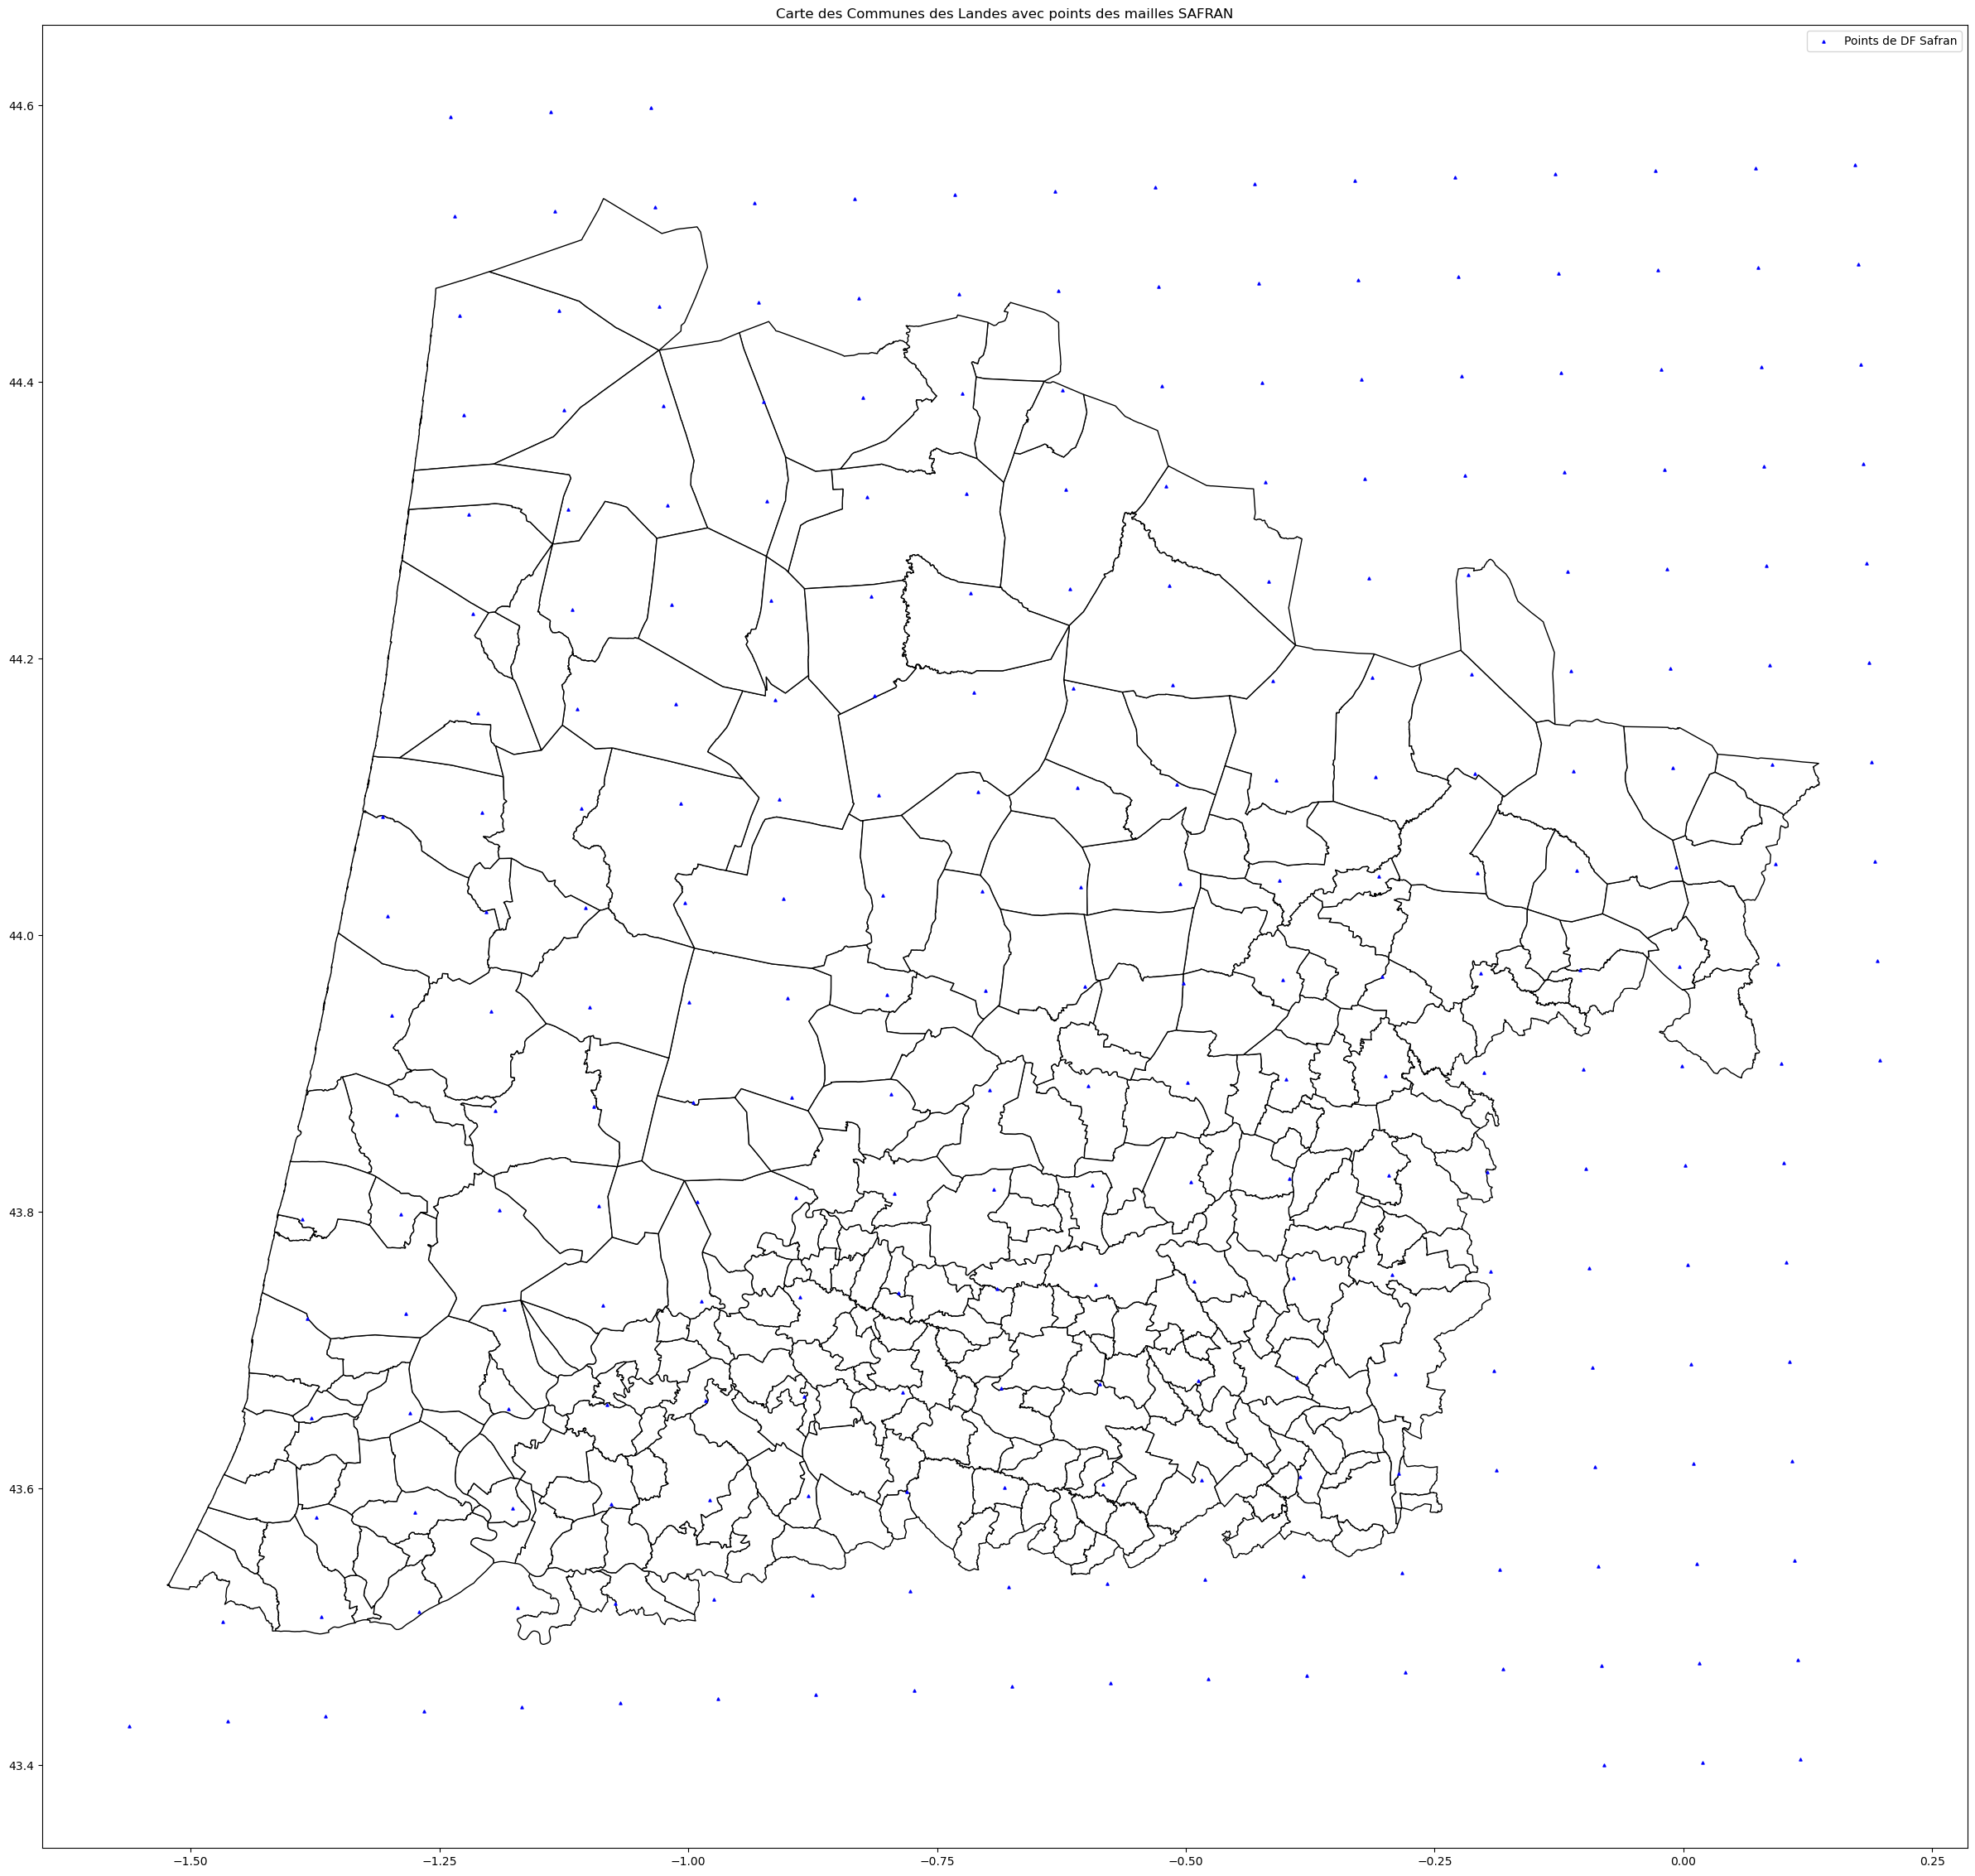

In [16]:
# On reprend le code précédent

geo_df_safran = geo_df_safran.set_crs(epsg=4326)  # WGS 84
communes_landes = communes_landes.to_crs(epsg=4326)  # Convertir si différent

fig, ax = plt.subplots(figsize=(30, 30))
communes_landes.plot(ax=ax, color='white', edgecolor='black')

# Ajouter les points de geo_data_landes et à la carte
geo_df_safran.plot(ax=ax, marker='^', color='blue', markersize=5, label='Points de DF Safran')

plt.title('Carte des Communes des Landes avec points des mailles SAFRAN')
plt.legend()

plt.show()

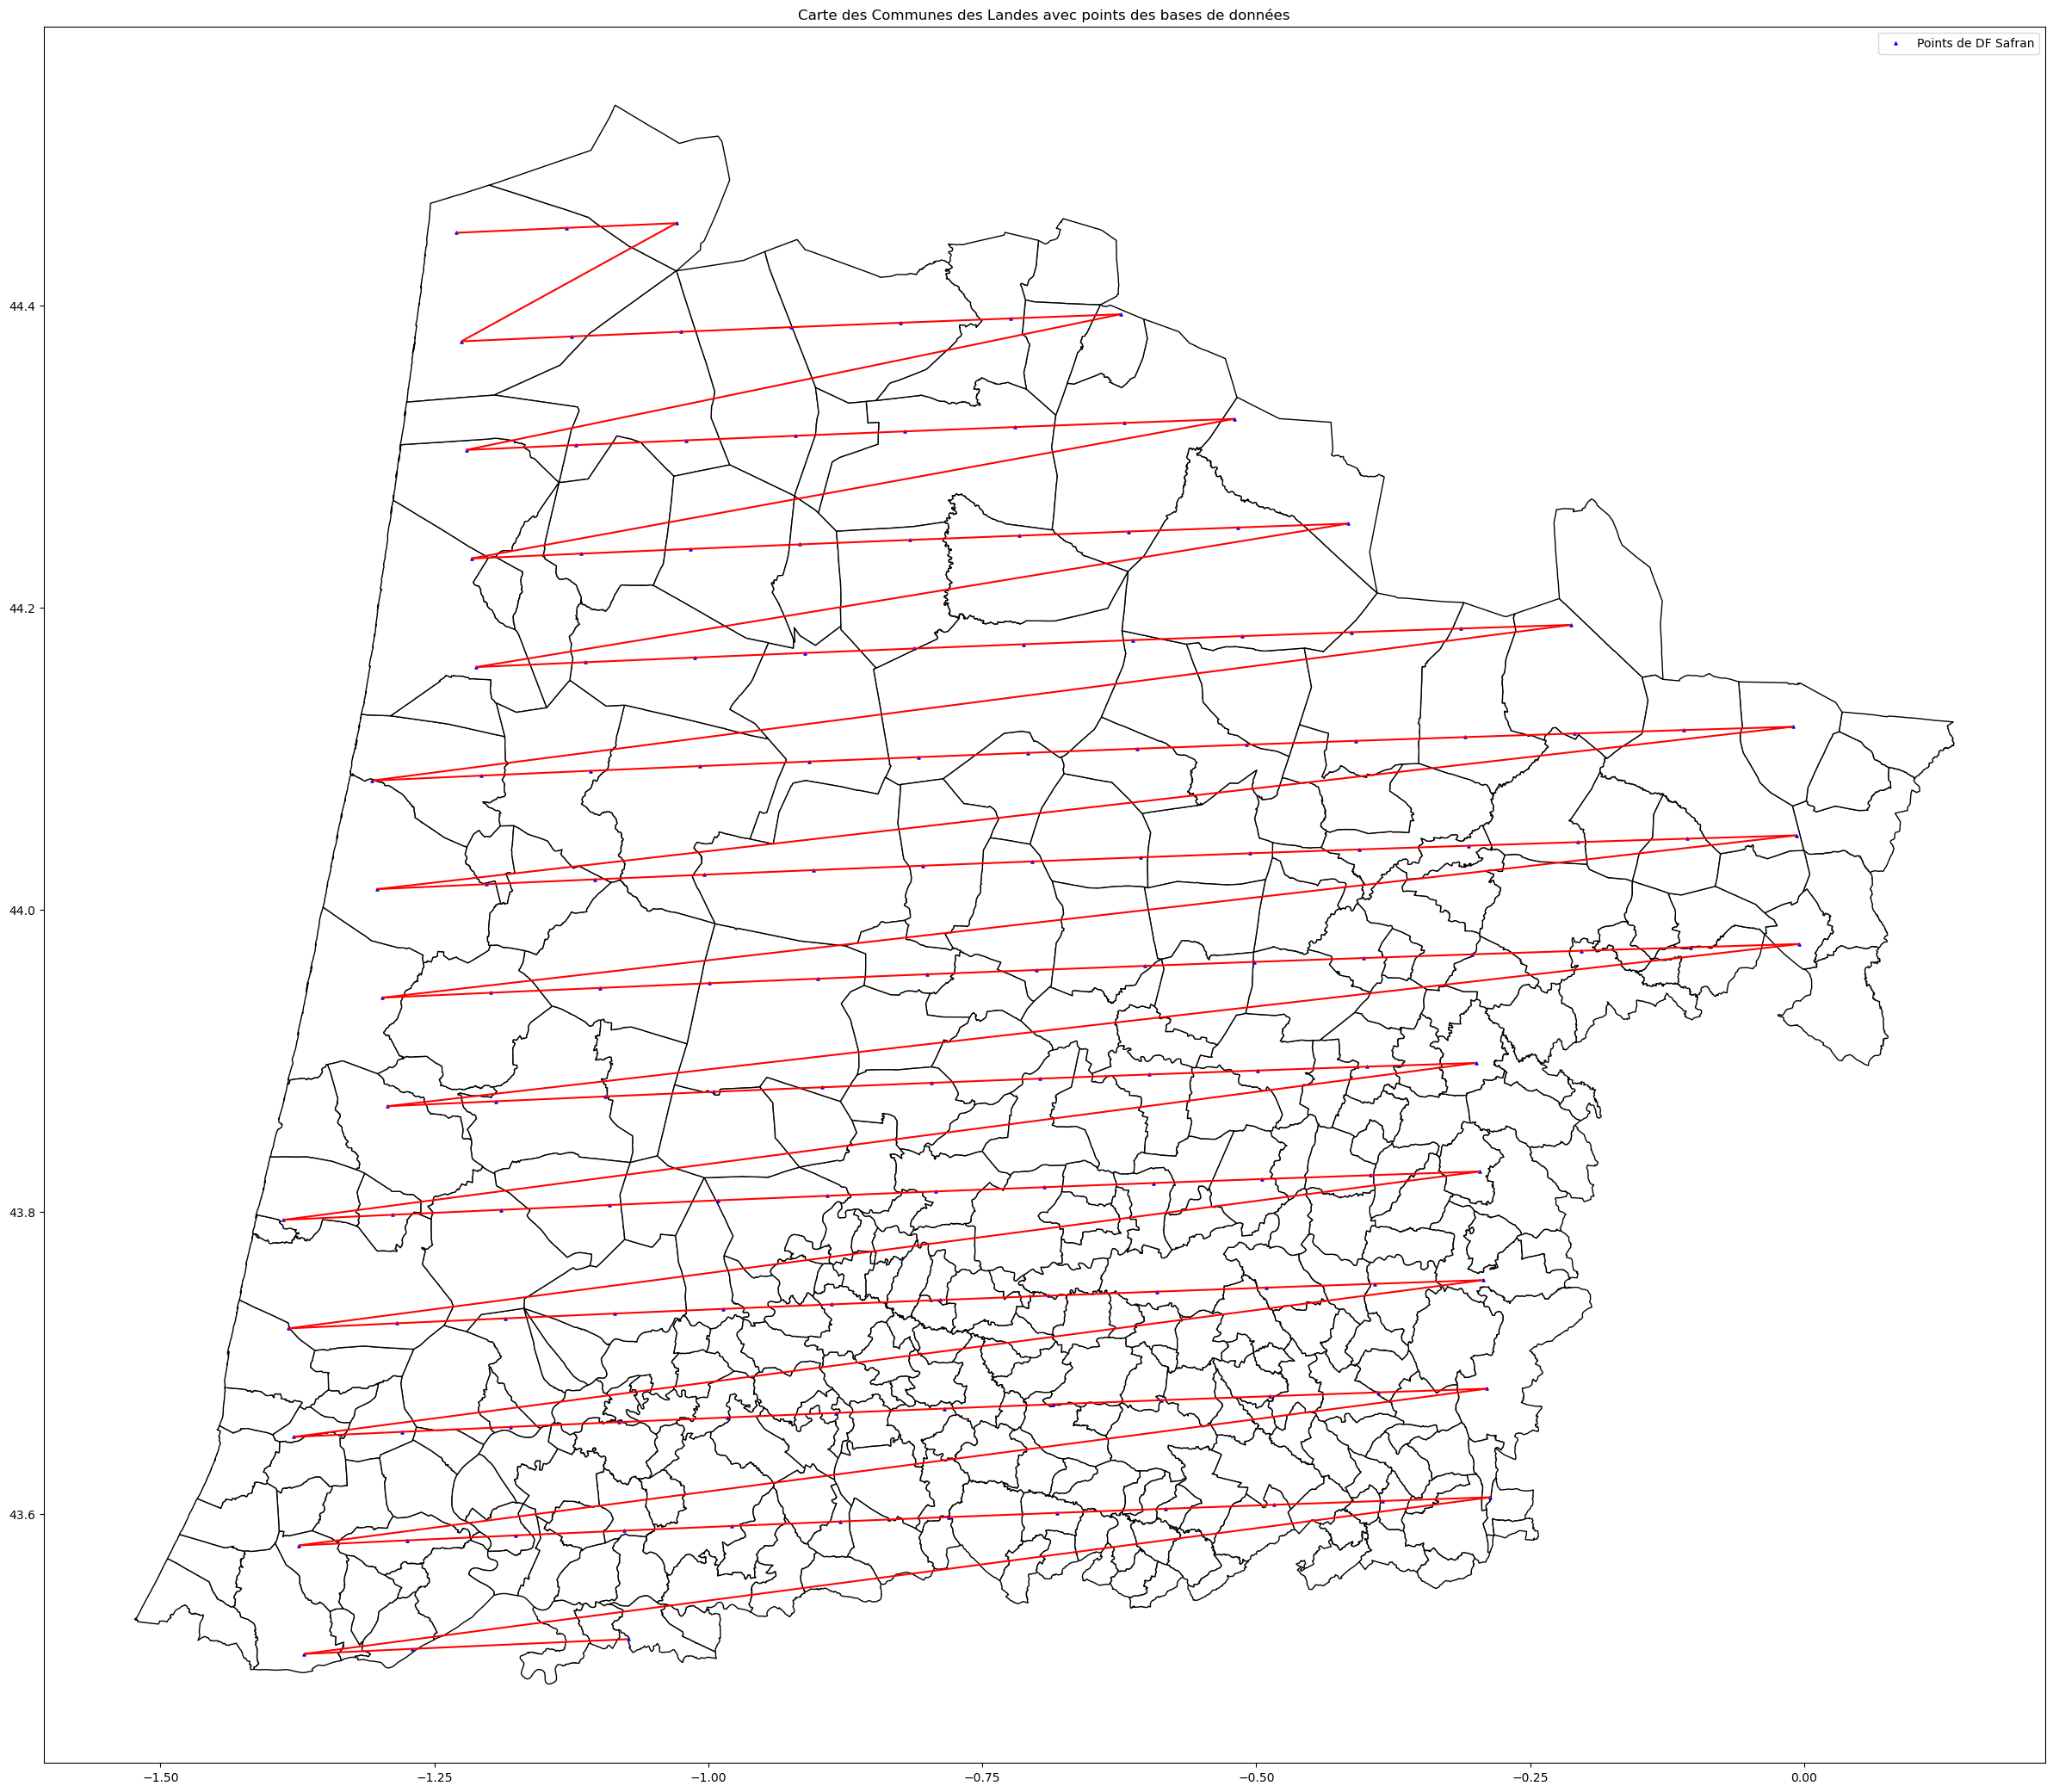

In [44]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

# Création d'un GeoDataFrame à partir de vos points SAFRAN

geometry_safran = [Point(xy) for xy in zip(df_safran['longitude'], df_safran['latitude'])]
geo_df_safran = gpd.GeoDataFrame(df_safran, geometry=geometry_safran)

geo_df_safran = geo_df_safran.set_crs(epsg=4326)  # WGS 84
communes_landes = communes_landes.to_crs(epsg=4326)  # Convertir si différent

fig, ax = plt.subplots(figsize=(30, 30))
communes_landes.plot(ax=ax, color='white', edgecolor='black')

# Ajouter les points de geo_data_landes et à la carte
geo_df_safran.plot(ax=ax, marker='^', color='blue', markersize=5, label='Points de DF Safran')

# Connecter les points adjacents pour former un quadrillage
for i in range(len(geometry_safran)-1):
    # Assurez-vous de connecter logiquement les points, peut-être par proximité ou par un autre critère
    line = LineString([geometry_safran[i], geometry_safran[i+1]])
    gpd.GeoSeries([line], crs="EPSG:4326").plot(ax=ax, color='red')


plt.title('Carte des Communes des Landes avec points des bases de données')
plt.legend()

plt.show()

##MOCHE, on reprends ça après dans le code

# 3- Test de jointure des mailles SAFRAN aux communes

On va essayer d'associer à chaque point une commune, afin de pouvoir l'appliquer aux points des mailles SAFRAN

In [45]:
## On efffectue une jointure spatiale des data frame. A chaque point de la maille safran, déterminé par sa latitude 
##et longitude, on associe spatialement la commune dans laquelle il est (INSEE_COM)
## c'est à dire que tous les points de coordonnées des mailles sont associés à une seule commune, et une commune
## peut être associée à plusieurs maille

joined_data = gpd.sjoin(geo_df_safran, communes_landes, how="inner", op='intersects')
print(joined_data.head())


   Unnamed: 0  maille_safran  maille_drias   latitude  longitude  altitude  \
0        6585           7741          5895  44.447977  -1.229972        28   
1        6586           7742          5896  44.451195  -1.129639        23   
2        6587           7743          5897  44.454322  -1.029295        36   
3        6666           7823          5752  44.376109  -1.225422        28   
4        6667           7824          5753  44.379323  -1.125217        32   

   departement region_avant_2016          region2016          nature  ...  \
0  40 - Landes         Aquitaine  Nouvelle-Aquitaine  Limite côtière  ...   
1  40 - Landes         Aquitaine  Nouvelle-Aquitaine      Territoire  ...   
2  40 - Landes         Aquitaine  Nouvelle-Aquitaine      Territoire  ...   
3  40 - Landes         Aquitaine  Nouvelle-Aquitaine  Limite côtière  ...   
4  40 - Landes         Aquitaine  Nouvelle-Aquitaine      Territoire  ...   

   INSEE_COM          STATUT  POPULATION  INSEE_CAN  INSEE_ARR  INSE

/opt/mamba/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [46]:
# Dictionnaire où chaque clé est un code INSEE et chaque valeur est une liste de mailles avec leurs coordonnées
communes_to_mailles = {}

for insee, group in joined_data.groupby('INSEE_COM'):
    # Stocker les mailles et leurs coordonnées dans une liste de dictionnaires
    mailles_info = group.apply(lambda row: {'maille_safran': row['maille_safran'], 'longitude': row['longitude'], 'latitude': row['latitude']}, axis=1).tolist()
    communes_to_mailles[insee] = mailles_info

# Afficher un exemple du dictionnaire
for key, value in communes_to_mailles.items():
    print(f"Commune INSEE: {key}, Mailles: {value}")



Commune INSEE: 40001, Mailles: [{'maille_safran': 8727, 'longitude': -0.289658685061804, 'latitude': 43.6828913046202}]
Commune INSEE: 40004, Mailles: [{'maille_safran': 8716, 'longitude': -1.3784077336823, 'latitude': 43.6509833834393}]
Commune INSEE: 40006, Mailles: [{'maille_safran': 8268, 'longitude': -0.804488143667384, 'latitude': 44.029040480682}]
Commune INSEE: 40008, Mailles: [{'maille_safran': 7829, 'longitude': -0.624024507843836, 'latitude': 44.3940197056465}]
Commune INSEE: 40011, Mailles: [{'maille_safran': 8810, 'longitude': -0.780766866853246, 'latitude': 43.5978965095434}]
Commune INSEE: 40014, Mailles: [{'maille_safran': 8272, 'longitude': -0.405971023623398, 'latitude': 44.0398094711338}]
Commune INSEE: 40020, Mailles: [{'maille_safran': 8544, 'longitude': -0.594096211807855, 'latitude': 43.8189980117494}]
Commune INSEE: 40021, Mailles: [{'maille_safran': 8537, 'longitude': -1.28861780266914, 'latitude': 43.7980035284503}]
Commune INSEE: 40025, Mailles: [{'maille_saf

*Vérification qu'on a bien toutes les communes des Landes dans ce dictionnaire car j'ai un doute*

In [47]:
# Liste des codes INSEE des communes des Landes
codes_insee_communes = set(communes_landes['INSEE_COM'].unique())
print(f"Nombre de communes dans le GeoDataFrame : {len(codes_insee_communes)}")

# Clés du dictionnaire qui sont les codes INSEE
codes_insee_dict = set(communes_to_mailles.keys())
print(f"Nombre de communes dans le dictionnaire : {len(codes_insee_dict)}")

# Vérifier si des codes INSEE sont manquants dans le dictionnaire
missing_insee = codes_insee_communes.difference(codes_insee_dict)
print(f"Codes INSEE manquants dans le dictionnaire : {missing_insee}")

# Vérifier si des codes sont présents dans le dictionnaire mais pas dans le GeoDataFrame (improbable mais pour exhaustivité)
extra_insee = codes_insee_dict.difference(codes_insee_communes)
print(f"Codes INSEE présents dans le dictionnaire mais pas dans les données des communes : {extra_insee}")


Nombre de communes dans le GeoDataFrame : 327
Nombre de communes dans le dictionnaire : 112
Codes INSEE manquants dans le dictionnaire : {'40069', '40017', '40043', '40222', '40132', '40290', '40122', '40072', '40023', '40171', '40042', '40178', '40114', '40314', '40139', '40308', '40202', '40247', '40320', '40228', '40211', '40255', '40128', '40116', '40063', '40127', '40145', '40081', '40126', '40206', '40070', '40148', '40196', '40258', '40121', '40194', '40044', '40324', '40039', '40031', '40238', '40298', '40277', '40185', '40109', '40235', '40334', '40151', '40312', '40156', '40204', '40101', '40061', '40232', '40300', '40052', '40231', '40286', '40249', '40100', '40036', '40118', '40207', '40055', '40079', '40190', '40201', '40209', '40226', '40092', '40187', '40133', '40160', '40016', '40174', '40301', '40166', '40029', '40050', '40253', '40271', '40219', '40177', '40091', '40035', '40108', '40212', '40289', '40173', '40328', '40299', '40321', '40316', '40239', '40062', '40071'

/tmp/ipykernel_239/1584419430.py:6: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


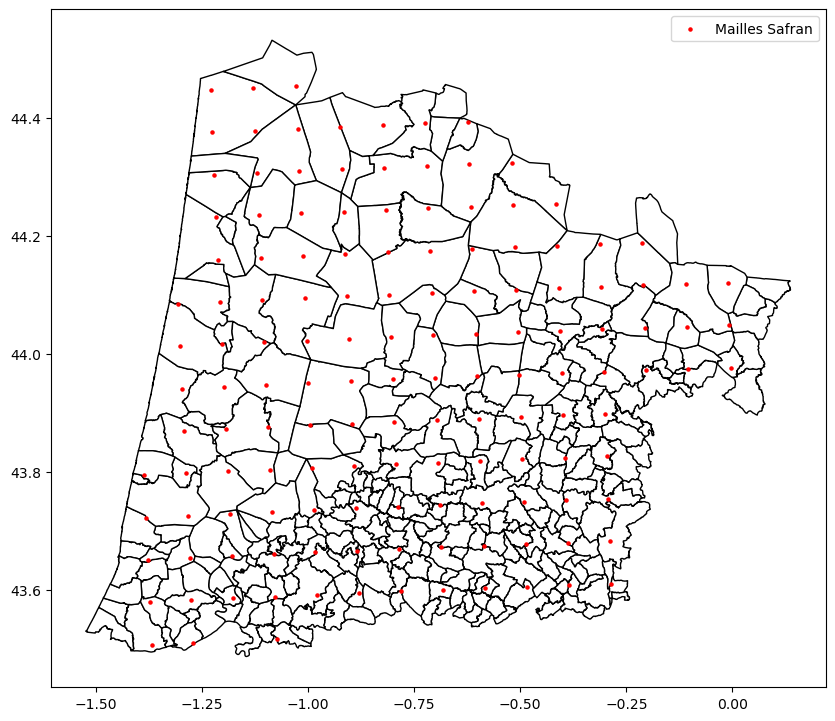

In [48]:
## pour vérifier d'ou vient le problème

fig, ax = plt.subplots(figsize=(10, 10))
communes_landes.plot(ax=ax, color='white', edgecolor='black', label='Communes')
geo_df_safran.plot(ax=ax, color='red', marker='o', markersize=5, label='Mailles Safran')
plt.legend()
plt.show()


*Il nous manque des communes car on n'a regardé que les coins des mailles et pas la maille en tant que carré*

/tmp/ipykernel_239/3887940614.py:31: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


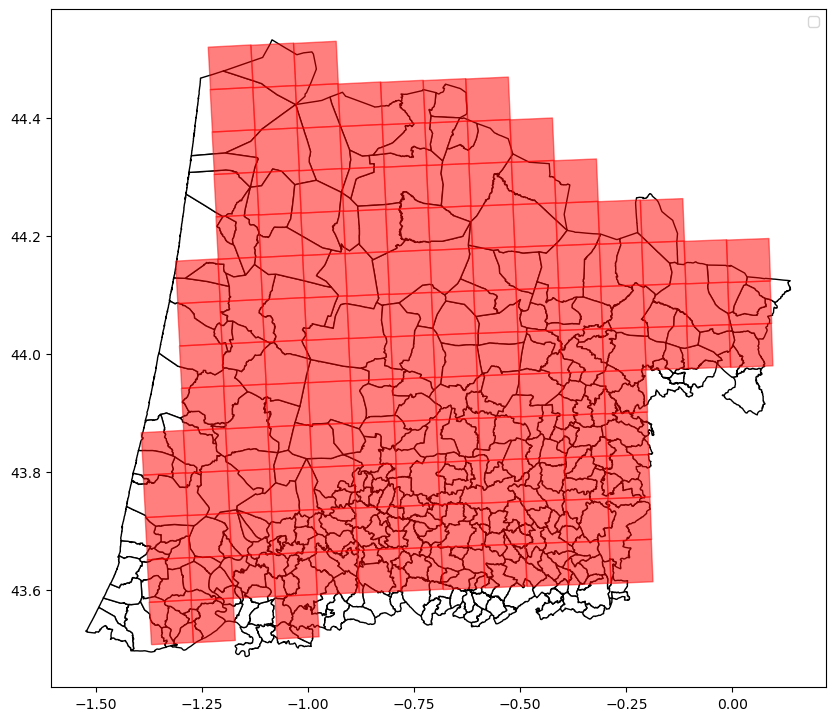

In [49]:
##1- on créé les polygones correspondant aux mailles safran, et on vérifie sur une carte

# Convertir les points en coordonnées projetées (Lambert 93 par exemple)
geo_df_safran['geometry'] = [Point(xy) for xy in zip(geo_df_safran.longitude, geo_df_safran.latitude)]
geo_df_safran = gpd.GeoDataFrame(geo_df_safran, crs='EPSG:4326')  # Assurez-vous que le CRS est WGS84
geo_df_safran = geo_df_safran.to_crs(epsg=2154)  # Reprojection en Lambert 93

# Fonction pour créer un polygone de maille à partir d'un point (coin inférieur gauche)
def create_square(point, size):
    return Polygon([
        (point.x, point.y),
        (point.x + size, point.y),
        (point.x + size, point.y + size),
        (point.x, point.y + size),
        (point.x, point.y)  # Fermeture du polygone
    ])

# Taille de la maille SAFRAN en mètres
size = 8000  # 8 km

# Création des polygones de maille SAFRAN
geo_df_safran['geometry'] = geo_df_safran.apply(lambda row: create_square(row.geometry, size), axis=1)
mailles_polygons = geo_df_safran.copy()

# Reprojection des polygones en coordonnées géographiques pour visualisation
mailles_polygons = mailles_polygons.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 10))
communes_landes.to_crs(epsg=4326).plot(ax=ax, color='white', edgecolor='black', label='Communes')
mailles_polygons.plot(ax=ax, color='red', alpha=0.5, edgecolor='red', label='Mailles Safran')
plt.legend()
plt.show()


In [52]:
##2- On fait la jointure avec les polygones

communes_landes = communes_landes.to_crs(epsg=2154)
mailles_polygons = mailles_polygons.to_crs(epsg=2154)

print("CRS de communes_landes:", communes_landes.crs)
print("CRS de mailles_polygons:", mailles_polygons.crs)

joined_data = gpd.sjoin(communes_landes, mailles_polygons, how="inner", predicate='intersects')
print(joined_data)


CRS de communes_landes: EPSG:2154
CRS de mailles_polygons: EPSG:2154
                           id    ID                      NOM  \
0    COMMUNE_0000000009758658  None     Labastide-d'Armagnac   
0    COMMUNE_0000000009758658  None     Labastide-d'Armagnac   
0    COMMUNE_0000000009758658  None     Labastide-d'Armagnac   
1    COMMUNE_0000000009759609  None  Saint-Geours-de-Maremne   
1    COMMUNE_0000000009759609  None  Saint-Geours-de-Maremne   
..                        ...   ...                      ...   
325  COMMUNE_0000000009758442  None                Roquefort   
325  COMMUNE_0000000009758442  None                Roquefort   
325  COMMUNE_0000000009758442  None                Roquefort   
325  COMMUNE_0000000009758442  None                Roquefort   
326  COMMUNE_0000000009758654  None  Saint-Julien-d'Armagnac   

                       NOM_M INSEE_COM          STATUT  POPULATION INSEE_CAN  \
0       LABASTIDE-D'ARMAGNAC     40131  Commune simple         691        08   
0 

In [53]:
##3- dico

commune_mailles_dict = {}

for name, group in joined_data.groupby('INSEE_COM'):
    mailles_list = group['maille_safran'].tolist()
    commune_mailles_dict[name] = mailles_list

# Dictionnaire avec le code INSEE de chaque commune et les mailles SAFRAN associées
print(commune_mailles_dict)


{'40001': [8815, 8814, 8727, 8726], '40002': [8810, 8809], '40003': [8718, 8628], '40004': [8804, 8716], '40005': [8813], '40006': [8268, 8360, 8359, 8267], '40008': [7912, 7911, 7829, 7828], '40011': [8810, 8809], '40012': [8545, 8546], '40013': [8547, 8456], '40014': [8363, 8364, 8273, 8272, 8271], '40015': [8276, 8185], '40016': [8813, 8812], '40017': [8724, 8723], '40018': [8631, 8541], '40019': [8082, 7991], '40020': [8634, 8633, 8544, 8543], '40021': [8627, 8626, 8537, 8536], '40022': [8814, 8726], '40023': [8722, 8721], '40024': [8723, 8633], '40025': [8635, 8545, 8636, 8546], '40026': [8634], '40028': [8810, 8809], '40029': [8813, 8812], '40030': [8276], '40031': [8631, 8541, 8540], '40032': [7911, 7828], '40033': [8271], '40034': [8806], '40035': [8807], '40036': [8804, 8716], '40037': [8635, 8634, 8545, 8544], '40038': [8810, 8722], '40039': [8366], '40040': [8451, 8450], '40042': [8894, 8893], '40043': [8173, 8172], '40044': [8893], '40046': [7906, 7823, 7741, 7907, 7824, 77

In [54]:
##On vérifie qu'on a bien toutes les communes

# Liste des codes INSEE des communes des Landes
codes_insee_communes = set(communes_landes['INSEE_COM'].unique())
print(f"Nombre de communes dans le GeoDataFrame : {len(codes_insee_communes)}")

# Clés du dictionnaire qui sont les codes INSEE
codes_insee_dict = set(commune_mailles_dict.keys())
print(f"Nombre de communes dans le dictionnaire : {len(codes_insee_dict)}")

# Vérifier si des codes INSEE sont manquants dans le dictionnaire
missing_insee = codes_insee_communes.difference(codes_insee_dict)
print(f"Codes INSEE manquants dans le dictionnaire : {missing_insee}")

# Vérifier si des codes sont présents dans le dictionnaire mais pas dans le GeoDataFrame (improbable mais pour exhaustivité)
extra_insee = codes_insee_dict.difference(codes_insee_communes)
print(f"Codes INSEE présents dans le dictionnaire mais pas dans les données des communes : {extra_insee}")


Nombre de communes dans le GeoDataFrame : 327
Nombre de communes dans le dictionnaire : 303
Codes INSEE manquants dans le dictionnaire : {'40312', '40225', '40232', '40136', '40290', '40189', '40065', '40007', '40209', '40047', '40226', '40218', '40041', '40206', '40133', '40148', '40224', '40223', '40027', '40073', '40214', '40120', '40176', '40173'}
Codes INSEE présents dans le dictionnaire mais pas dans les données des communes : set()


*Il faudra mettre à la main celles restanes car elles sont aux frontières donc hors maille*

idée, prendre des mailles autour, je pense qu'elles y sont mais ne sont pas localisées sur le département landes, donc puet être au lieu de restreindre les mailles à la condition landes, prendre des lat et longitudes max